# 모듈

In [1]:
# 모듈 가져오기
import tensorflow as tf
tf.__version__

'2.8.2'

In [2]:
from tensorflow import keras
keras.__version__

'2.8.0'

# 데이터 준비

In [3]:
# 데이터
from tensorflow.keras.datasets import fashion_mnist

In [4]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

4431872/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
# 이미지 데이터 포멧확인을 위해 케라스의 기반 엔진 획득
from tensorflow.keras import backend
# NHWC (60000, 28, 28, 1)
fmt = backend.image_data_format()
fmt

'channels_last'

In [6]:
# 환경변수 ( 데이터 )
import numpy as np
_, PIXEL_H, PIXEL_W = X_train.shape
PIXELS = PIXEL_H*PIXEL_W
LABEL_NUM = len( np.unique( y_train ) )
INPUT_CH = 1

In [7]:
# 입력을 위한 shape 정리 NHWC, 3D -> 4D
if fmt == 'channels_last':
  X_train = X_train.reshape( -1, PIXEL_H, PIXEL_W, INPUT_CH )
  X_test = X_test.reshape( -1, PIXEL_H, PIXEL_W, INPUT_CH )
else:
  X_train = X_train.reshape( -1, INPUT_CH, PIXEL_H, PIXEL_W )
  X_test = X_test.reshape( -1, INPUT_CH, PIXEL_H, PIXEL_W )

In [8]:
# 정규화 0 ~ 255 -> 0 ~ 1 처리
X_train = X_train / np.max( X_train )
X_test = X_test / np.max( X_test )

In [9]:
X_train.max(), X_train.min(), X_test.max(), X_test.min(),

(1.0, 0.0, 1.0, 0.0)

In [10]:
# 정답은 범주형 데이터 -> one-hot encoding -> 0과 1의 조합으로 표현된다
# 데이터는 늘어나지만 (60000,1) -> (60000,10) : 학습성능을 높이기 위해
y_train = keras.utils.to_categorical( y_train,LABEL_NUM )
y_test = keras.utils.to_categorical( y_test,LABEL_NUM )

In [11]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [12]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

# 모델 구축

In [13]:
from tensorflow.keras import models, layers

In [14]:
model = models.Sequential()

In [15]:
# input_shape = 참일때 값 if 조건식 else 거짓일때 값
input_shape = ( PIXEL_H, PIXEL_W, INPUT_CH ) if fmt == 'channels_last' else ( INPUT_CH, PIXEL_H, PIXEL_W  )
input_shape

(28, 28, 1)

In [16]:
# conversion
model.add( layers.Conv2D(
    32, # 출력채널 수
    kernel_size = (5,5), # 커널의 크기
    strides=(1, 1), # 커널의 이동량
    padding='same', # 합성곱을 통과한 feature map의 크기도 동일하게 28로 유지하기 위해 보정
    activation='relu', # 활성화함수를 통과한 결과물 activation map
    input_shape=input_shape # 첫번째 합성곱층에서만 정의, 입력되는 데이터의 형태를 지정
) )
model.add( layers.MaxPool2D(  
    pool_size=(2,2),  # 커널의 크기
    strides=None,     # none 이면 커널과 동사이즈 -> 2 -> activation map의 크기는 반으로 줄어든다
    padding='valid'   # 보정
) )
model.add( layers.Dropout(0.1) )
# conversion
model.add( layers.Conv2D( 32*2,(5,5),padding='same',activation='relu') )
model.add( layers.MaxPool2D( padding='same' ) )
model.add( layers.Dropout(0.1) )
# fc
model.add( layers.Flatten() )
model.add( layers.Dense( 1024, activation='relu' ) )
# output
model.add( layers.Dropout(0.1) )
model.add( layers.Dense( LABEL_NUM, activation='softmax' ) )

In [17]:
# 컴파일 환경 구성 ( 학습시, 손실값 획득, 최적화, ... )
model.compile(
    optimizer='adam',
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

# 학습

In [18]:
# 환경변수
EPOCH = 30
BATCH_SIZE = 64

In [19]:
# 조기학습 종료
from tensorflow.keras.callbacks import EarlyStopping

# 5회 이상 val_loss 값의 변화가 거의 없다면 조기학습 종료 진행
earlyStopping = EarlyStopping( patience=5 )

In [20]:
# 학습
# 훈련 데이터의 20%는 검증용
with tf.device('/device:GPU:0'):
  hist = model.fit( X_train, y_train, BATCH_SIZE, EPOCH, callbacks=[ earlyStopping ], validation_split=0.2 )

Epoch 1/30
750/750 [==============================] - 16s 6ms/step - loss: 0.4383 - accuracy: 0.8397 - val_loss: 0.3157 - val_accuracy: 0.8901
Epoch 2/30
750/750 [==============================] - 4s 5ms/step - loss: 0.2872 - accuracy: 0.8950 - val_loss: 0.2644 - val_accuracy: 0.9070
Epoch 3/30
750/750 [==============================] - 4s 5ms/step - loss: 0.2432 - accuracy: 0.9090 - val_loss: 0.2512 - val_accuracy: 0.9082
Epoch 4/30
750/750 [==============================] - 4s 5ms/step - loss: 0.2149 - accuracy: 0.9194 - val_loss: 0.2375 - val_accuracy: 0.9110
Epoch 5/30
750/750 [==============================] - 4s 5ms/step - loss: 0.1888 - accuracy: 0.9290 - val_loss: 0.2222 - val_accuracy: 0.9184
Epoch 6/30
750/750 [==============================] - 4s 5ms/step - loss: 0.1686 - accuracy: 0.9362 - val_loss: 0.2316 - val_accuracy: 0.9187
Epoch 7/30
750/750 [==============================] - 4s 5ms/step - loss: 0.1473 - accuracy: 0.9454 - val_loss: 0.2400 - val_accuracy: 0.9177
Epoch

In [21]:
# 테스트
model.evaluate( X_test,y_test )
# 과적합일 수 있음
# 313/313 [==============================] - 1s 3ms/step - loss: 0.2750 - accuracy: 0.9178
# [0.2749672830104828, 0.9178000092506409]
# 검증용 훈련용 테스트용 정확도 결과를 보고 모델 조정, 수치 조정, 데이터 조정등 작업 진행

313/313 [==============================] - 1s 3ms/step - loss: 0.2750 - accuracy: 0.9178


[0.2749672830104828, 0.9178000092506409]

In [24]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

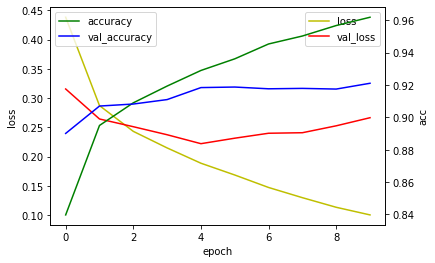

In [27]:
# 학습 결과 시각화
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
# y축 양쪽을 다 사용하기위해서
acc_ax = ax.twinx()

# loss
ax.plot(hist.history['loss'],'y',label='loss')
ax.plot(hist.history['val_loss'],'r',label='val_loss')

# acc
acc_ax.plot(hist.history['accuracy'],'g',label='accuracy')
acc_ax.plot(hist.history['val_accuracy'],'b',label='val_accuracy')

# 축에 이름 부여
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
acc_ax.set_ylabel('acc')

ax.legend()
acc_ax.legend()

plt.show()